In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ix
import networkx as nx
import graphistry

In [3]:
data_path = '/public/npatil4/networks/data/combined/'

In [4]:
file_year = data_path + 'data_2015_withNodes_year.txt'
data_year = pd.read_csv(file_year,
                        sep='|')

In [5]:
def data_limited2(df):
    
    mask = (
        (data_year.pick_long.between(-74.02,-73.92).values) & 
        (data_year.pick_lat.between(40.70,40.85).values) &
        (data_year.drop_long.between(-74.02,-73.92).values) & 
        (data_year.drop_lat.between(40.70,40.85).values)
        )
    
    return(mask)

##### Trips in manhattan

In [6]:
mask = (data_limited2(data_year))
print 'Routes : ',sum(mask)
print 'Trips : ',data_year.trips[mask].sum()

Routes :  11146000
Trips :  125169721


##### Trips in manhattan >=500

In [7]:
mask1 = (data_limited2(data_year)) & (data_year['trips']>=500)
print 'Routes : ',sum(mask1)
print 'Trips : ',sum(data_year.trips[mask1])

Routes :  7542
Trips :  6163359


##### Trips in manhattan <500

In [8]:
mask2 = (data_limited2(data_year)) & (data_year['trips']<500)
print 'Routes : ',sum(mask2)
print 'Trips : ',sum(data_year.trips[mask2])

Routes :  11138458
Trips :  119006362


##### Graph Generation and total nodes

In [9]:
data_nwk =nx.DiGraph()
data_nwk = nx.from_pandas_dataframe(df = data_year[mask],
                                    source='start',
                                    target='stop',
                                    edge_attr=['trips'],
                                    create_using=data_nwk)

In [10]:
data_nwk1 =nx.DiGraph()
data_nwk1 = nx.from_pandas_dataframe(df = data_year[mask1],
                                    source='start',
                                    target='stop',
                                    edge_attr=['trips'],
                                    create_using=data_nwk1)

In [11]:
data_nwk2 =nx.DiGraph()
data_nwk2 = nx.from_pandas_dataframe(df = data_year[mask2],
                                    source='start',
                                    target='stop',
                                    edge_attr=['trips'],
                                    create_using=data_nwk2)

In [12]:
{
    'All':data_nwk.number_of_nodes(),
    'Frequent':data_nwk1.number_of_nodes(),
    'in-frequent':data_nwk2.number_of_nodes()
}

{'All': 13925, 'Frequent': 1309, 'in-frequent': 13925}

#### Degree distrbution of the graph

degree_plot = plt.figure(figsize=(15,6))
sns.set_style('whitegrid')

degree_sequence = sorted(data_nwk.out_degree().values(),
                         reverse=True)

degree_plot.add_subplot(121)

plt.loglog(degree_sequence,
           'b-',
           marker='.',
           markersize =2,
           rasterized=False)
plt.title("Degree-rank plot : All trips")
plt.ylabel("degree")
plt.xlabel("rank")


degree_sequence = sorted(data_nwk1.out_degree().values(),
                         reverse=True)
degree_plot.add_subplot(122)

plt.loglog(degree_sequence,
           'b-',
           marker='.',
           markersize =2,
           rasterized=False)
plt.title("Degree-rank plot : In-frequent trips")
plt.ylabel("degree")
plt.xlabel("rank")


plt.savefig('../plots/DegreeDistribution.png',dpi=900)

#### Graph Analysis

In [13]:
graph = data_nwk1
pos_map = {x:(eval(x)[1],eval(x)[0]) for x in graph.nodes()}
degree_in = graph.in_degree()
degree_out = graph.out_degree()
degree = graph.degree()

In [14]:
edges = data_year[mask][['start','stop','trips','charge','dist_trip']]

In [15]:
data_year_coordinates = [
    [x,
     float(x.split(',')[0].replace('(','')),
     float(x.split(',')[1].replace(')','')),
     degree[x],
     degree_out[x],
     degree_in[x],
     list(pos_map[x])[0],
     list(pos_map[x])[1]
     ]
 for x in graph.nodes()
]

data_year_coordinates = pd.DataFrame(data_year_coordinates,
                                     columns=['node',
                                              'x',
                                              'y',
                                              'degree',
                                              'out_degree',
                                              'in_degree',
                                              'y_circ',
                                              'x_circ'])

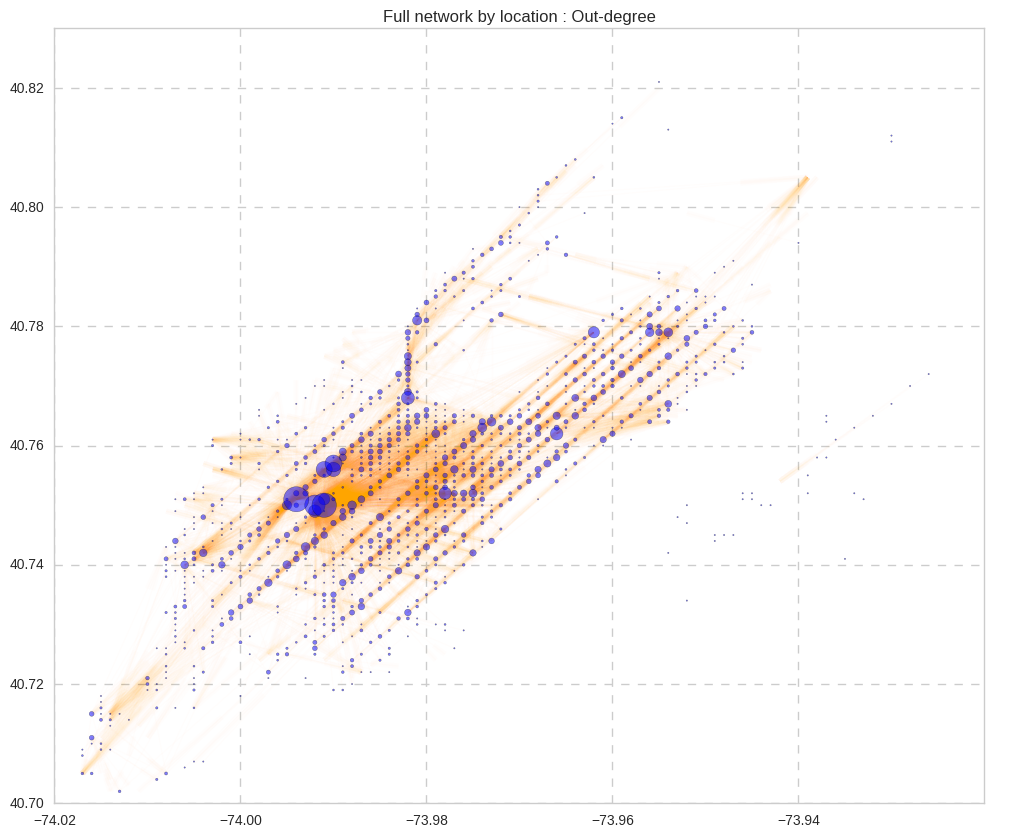

In [16]:
plt.figure(figsize=(12,10))
sns.set_style('whitegrid')


nx.draw_networkx_nodes(graph,
                 pos = pos_map,
                 node_list=[graph.nodes()],
                 node_size=[degree_out[key] for key in graph.nodes()],
                 node_color='blue',
                 alpha = 0.5,
                 dpi=600)

nx.draw_networkx_edges(graph,
                 pos = pos_map,
                 edge_color='orange',
                 alpha = 0.01)

plt.ticklabel_format(useOffset=False)
plt.grid(False, linestyle='--')

sns.plt.ylim((40.70,40.83))
sns.plt.xlim((-74.02,-73.92))
plt.title('Full network by location : Out-degree')


plt.savefig('../plots/OriginalNetwork_degree_out.png',dpi=800)

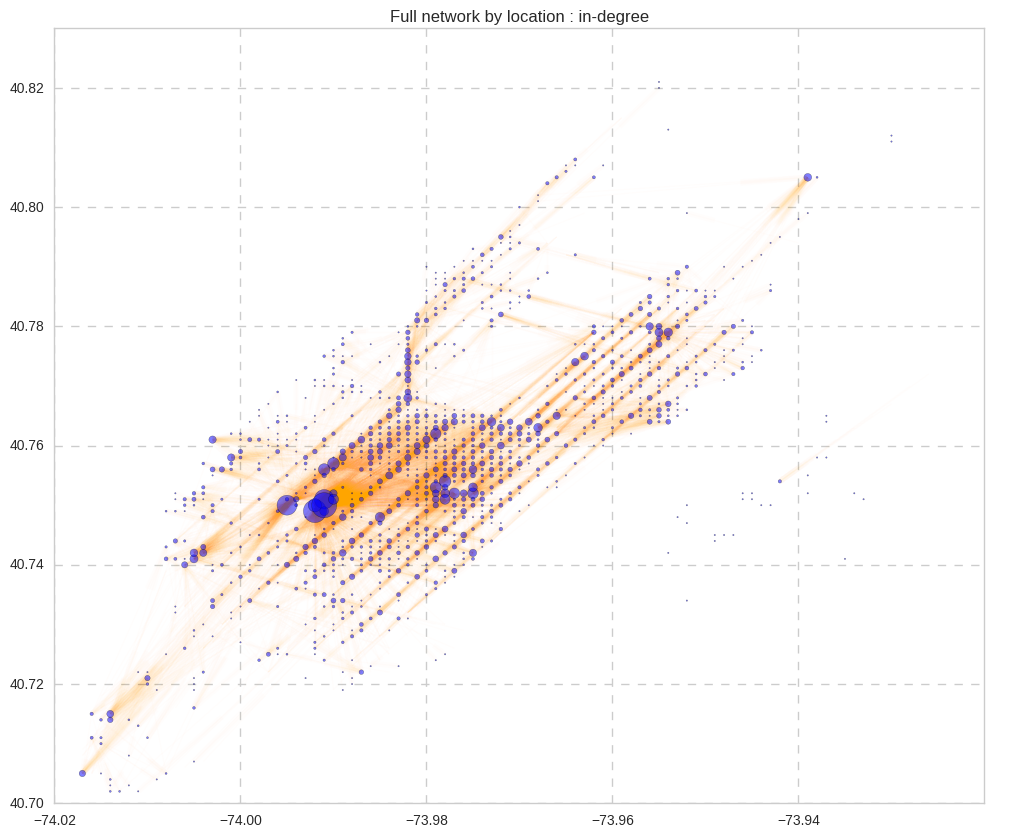

In [17]:
plt.figure(figsize=(12,10))
sns.set_style('whitegrid')


nx.draw_networkx_nodes(graph,
                 pos = pos_map,
                 node_list=[graph.nodes()],
                 node_size=[degree_in[key] for key in graph.nodes()],
                 node_color='blue',
                 alpha = 0.5,
                 dpi=600)

nx.draw_networkx_edges(graph,
                 pos = pos_map,
                 edge_color='orange',
                 alpha = 0.01)

plt.ticklabel_format(useOffset=False)
plt.grid(False, linestyle='--')

sns.plt.ylim((40.70,40.83))
sns.plt.xlim((-74.02,-73.92))
plt.title('Full network by location : in-degree')


plt.savefig('../plots/OriginalNetwork_degree_in.png',dpi=800)

#### Upload data to graphistry

key = '6c13090d289176e8d77fe2f86bb27e07d0b7ce0b12e117d2dc5a67123e4ca52192e873b3ef53cf771f8619a651c1a156fa36c310979eb0f1998c9953e0868990'

graphistry.register(key=key)

bindings = graphistry.nodes(data_year_coordinates[['node','x','y']]).edges(edges[edges.trips>=100]).bind(source='start',
                                                                     destination='stop',
                                                                     node='node',
                                                                     edge_weight='trips')

bindings2 = bindings.settings(url_params={'play':0})

bindings2.plot()

## Census tracts

#### Map geo-cordinates to census-tract

In [18]:
graph_census_tracts_2 = pd.read_csv('../data/graph_censusTract_full.txt',sep='|')
graph_census_tracts_2.columns = ['start_tract']+[str(x) for x in graph_census_tracts_2.columns[1:]]
for col in graph_census_tracts_2.columns:
    graph_census_tracts_2[col] = graph_census_tracts_2[col].astype('str')
    
    
graph_census_tracts_2['CENTLAT'] = graph_census_tracts_2.CENTLAT.astype('float')
graph_census_tracts_2['CENTLON'] = graph_census_tracts_2.CENTLON.astype('float')

In [19]:
data_use = data_year[mask].merge(graph_census_tracts_2[
                            ['CENTLAT','CENTLON','start_tract','GEOID']],
                left_on='start',right_on='start_tract').merge(
                            graph_census_tracts_2[
                            ['CENTLAT','CENTLON','start_tract','GEOID']],
                left_on='stop',right_on='start_tract')

In [20]:
columns = ['trips',
           'CENTLAT_x','CENTLON_x',
           'start_tract_x','GEOID_x',
           'CENTLAT_y','CENTLON_y',
           'start_tract_y','GEOID_y']

In [21]:
data_use=data_use[columns]

data_use.columns = ['trips',
                    'startLat','startLong','start_original','startGeoId',
                    'stopLat','stopLong','stop_original','stopGeoId']


data_use = data_use.groupby(['startGeoId','stopGeoId',
                             'startLat','startLong',
                             'stopLat','stopLong'],
                            as_index=False)['trips'].sum()

In [22]:
data_nwk3 = nx.DiGraph()
data_nwk3 = nx.from_pandas_dataframe(df = data_use,
                                    source='startGeoId',
                                    target='stopGeoId',
                                    edge_attr=['trips'],
                                    create_using=data_nwk3)

#### Plots by trips

In [ ]:
graph = data_nwk3


degree_in = graph.in_degree()
degree_out = graph.out_degree()
degree = graph.degree()
trips_out = {str(node) : sum(data_use[data_use.startGeoId==node].trips) 
             for node in graph.nodes()}
trips_in = {str(node) : sum(data_use[data_use.stopGeoId==node].trips) 
             for node in graph.nodes()}


pos_map = {}
for row_id,row in data_use.iterrows(): 
    pos_map[str(row[0])] = (float(row[3]),float(row[2]))
    pos_map[str(row[1])] = (float(row[5]),float(row[4]))
    
    
edges = data_use[['startGeoId','stopGeoId','trips']]

data_year_coordinates = [ [str(x),
                           degree[x],
                           degree_out[x],
                           degree_in[x],
                           trips_out[x],
                           trips_in[x],
                           pos_map[x][0],
                           pos_map[x][1]
                          ]
                          for x in graph.nodes()]

data_year_coordinates = pd.DataFrame(data_year_coordinates,
                                     columns=['node',
                                              'degree',
                                              'out_degree',
                                              'in_degree',
                                              'out_trips',
                                              'in_trips',
                                              'x',
                                              'y'
                                              ])

m = max(data_use.trips)
edgewidth = [d['trips']/m for (u,v,d) in graph.edges(data=True)]

In [ ]:
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')

nx.draw_networkx_nodes(graph,
                 pos = pos_map,
                 node_list=[graph.nodes()],
                 node_size=[2.5*trips_out[key]/m for key in graph.nodes()],
                 node_color='blue',
                 markeredgewidth=0.0,
                 alpha = 0.9)

nx.draw_networkx_edges(graph,
                 pos = pos_map,
                 alpha=0.1,
                 edge_color='orange',
                 width = 0.008)

plt.ticklabel_format(useOffset=False)
plt.grid(False, linestyle='--')

sns.plt.ylim((40.65,40.90))
sns.plt.xlim((-74.03,-73.90))
plt.title('Full network by census tract : Outgoing')


plt.savefig('../plots/Census_Tract_Network_trips_out.png',dpi=800)

In [ ]:
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')

nx.draw_networkx_nodes(graph,
                 pos = pos_map,
                 node_list=[graph.nodes()],
                 node_size=[2.5*trips_in[key]/m for key in graph.nodes()],
                 node_color='blue',
                 markeredgewidth=0.0,
                 alpha = 0.9)

nx.draw_networkx_edges(graph,
                 pos = pos_map,
                 alpha=0.1,
                 edge_color='orange',
                 width = 0.008)

plt.ticklabel_format(useOffset=False)
plt.grid(False, linestyle='--')

#sns.plt.ylim((40.65,40.90))
#sns.plt.xlim((-74.03,-73.90))
plt.title('Full network by census tract : Incoming')


plt.savefig('../plots/Census_Tract_Network_trips_in.png',dpi=800)

In [ ]:
key = '6c13090d289176e8d77fe2f86bb27e07d0b7ce0b12e117d2dc5a67123e4ca52192e873b3ef53cf771f8619a651c1a156fa36c310979eb0f1998c9953e0868990'

graphistry.register(key=key)

plotter = graphistry.bind(source="startGeoId",
                          destination="stopGeoId",
                          edge_weight='trips')

#### Community detection & plots

In [ ]:
ig2 = plotter.pandas2igraph(data_use)
ig2.vs['pagerank'] = ig2.pagerank()
ig2.to_undirected()
ig2.vs['community'] = ig2.community_multilevel().membership
ig2.vs['location'] = [pos_map[x['__nodeid__']] for x in ig2.vs]

plotter.bind(point_color='community', point_size='pagerank').plot(ig2)

In [ ]:
pos_dict = {x['__nodeid__']:x['location'] for x in ig2.vs}
com_dict = {x['__nodeid__']:x['community'] for x in ig2.vs}

In [ ]:
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')

nx.draw_networkx_nodes(graph,
                 pos = pos_map,
                 node_list=[graph.nodes()],
                 node_size=1,
                 node_color=[['blue',
                              'red',
                              'green'][com_dict[x]] for x in graph.nodes()]              ,
                 markeredgewidth=0.0,
                 alpha = 0.9)

nx.draw_networkx_edges(graph,
                 pos = pos_map,
                 alpha=0.1,
                 edge_color='orange',
                 width = 0.008)

plt.ticklabel_format(useOffset=False)
plt.grid(False, linestyle='--')

sns.plt.ylim((40.675,40.875))
sns.plt.xlim((-74.03,-73.90))
plt.title('Full network by census tract : Communities (In trips)')


plt.savefig('../plots/Census_Tract_Network_community_inTrips.png',
            dpi=800)

In [ ]:
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')

nx.draw_networkx_nodes(graph,
                 pos = pos_map,
                 node_list=[graph.nodes()],
                 node_size=[2.5*trips_out[key]/m for key in graph.nodes()],
                 node_color=[['blue',
                              'red',
                              'green'][com_dict[x]] for x in graph.nodes()]              ,
                 markeredgewidth=0.0,
                 alpha = 0.9)

nx.draw_networkx_edges(graph,
                 pos = pos_map,
                 alpha=0.1,
                 edge_color='orange',
                 width = 0.008)

plt.ticklabel_format(useOffset=False)
plt.grid(False, linestyle='--')

sns.plt.ylim((40.675,40.875))
sns.plt.xlim((-74.03,-73.90))
plt.title('Full network by census tract : Communities (Out trips)')


#plt.savefig('../plots/Census_Tract_Network_community_outTrips.png',
#            dpi=800)

In [ ]:
col_dict = {x:[pos_map[x],
               ['blue','red','green'][com_dict[x]]] for x in graph.nodes()}

In [ ]:
q = pd.DataFrame(col_dict).transpose()
q.columns = ['pos','color']

In [ ]:
q['pos'] = q.pos.astype('str')